
# Multi‑Maturity Calibration Demo (AAPL)

*This notebook shows an end‑to‑end workflow to calibrate three models across **multiple option maturities**:*

- **Heston** (semi‑analytic CF; fast & smooth objective)  
- **rBergomi** (rough volatility; Monte Carlo)  
- **Rough Heston** (rough volatility + mean reversion; Monte Carlo)

We will:

1. **Download real AAPL option data** with `yfinance`.
2. For a set of target tenors (e.g., 1m/3m/6m/1y), pick the **closest available expiries**.
3. **Infer** risk‑free `r` and dividend yield `q` from **put–call parity regression** per expiry.
4. Build one **clean call smile per expiry** (parity‑cleaned mids), then
5. Perform **joint calibration across maturities** for each model.
6. **Plot** the fitted smiles and report **global RMSEs** in price‑ and IV‑space.

> **Why multi‑maturity?**  
> Rough models shine when you fit *several maturities* (term structure of skew/forward variance).  
> For a single maturity, classic Heston often wins on both **speed** and **fit** because it uses a semi‑analytic characteristic function (smooth objective) while rough models are Monte Carlo (noisy & slower).



## 1) Environment setup & helper functions

*Notes:*
- We assume this notebook lives in `notebooks/` and the project root is one level up, so we append it to `sys.path`.
- We provide small **IV helpers** that map `(S,r,q)` to a **no‑dividend equivalent** via `S_eff = S e^{-qT}`, `r_eff = r-q` so we can reuse your `implied_volatility` solver.
- A tiny **calibration cache** (JSON) is included so repeated runs are instant.


In [12]:
import os, sys, math, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- project path ---
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if repo_root not in sys.path:
    sys.path.append(repo_root)

# --- project imports ---
from src.black_scholes import black_scholes_price
from src.volatility import implied_volatility
from src.heston import heston_price
from src.rough import rbergomi_paths, rough_heston_paths
from src.calibration import calibrate_rbergomi, calibrate_rough_heston, calibrate_cached

plt.rcParams["figure.figsize"] = (12,4)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 11

# --- IV helpers ---
def implied_vol_q(price, S, K, T, r, q, option_type="call"):
    Seff = S * math.exp(-q*T)
    reff = r - q
    return implied_volatility(price, Seff, K, T, reff, option_type=option_type)

def prices_to_ivs(S, r, q, T, strikes, prices, option_type="call"):
    ivs = []
    for K, p in zip(strikes, prices):
        try:
            ivs.append(implied_vol_q(p, S, K, T, r, q, option_type))
        except Exception:
            ivs.append(np.nan)
    return np.array(ivs, float)

WORKERS = min(12, os.cpu_count() or 12)
PAR_BACKEND = "process"  # use process pool for CPU-bound MC
TERMINAL_ONLY = True


In [13]:

# --- calibration cache wrappers ---
try:
    from src.calibration import calibrate_cached
except (ImportError, AttributeError):
    import importlib, src.rough as _rough
    importlib.reload(_rough)
    import src.calibration as _cal
    _cal = importlib.reload(_cal)
    calibrate_cached = _cal.calibrate_cached

CACHE_DIR = os.path.abspath(os.path.join(repo_root, "cache"))
os.makedirs(CACHE_DIR, exist_ok=True)

def _cache_overrides():
    return dict(n_workers=WORKERS, parallel_backend=PAR_BACKEND, terminal_only=TERMINAL_ONLY)

def calibrate_rbergomi_cached(smiles, metric, vega_weight, x0, mc, seed=1234,
                              bounds=None, multistart=2, options=None):
    overrides = _cache_overrides()
    return calibrate_cached(
        "rbergomi", calibrate_rbergomi,
        smiles=smiles, metric=metric, vega_weight=vega_weight, x0=x0, mc=mc,
        seed=seed, bounds=bounds, multistart=multistart, options=options,
        cache_dir=CACHE_DIR, runtime_overrides=overrides,
    )

def calibrate_rough_heston_cached(smiles, metric, vega_weight, x0, mc, seed=7777,
                                  bounds=None, multistart=2, options=None):
    overrides = _cache_overrides()
    return calibrate_cached(
        "rough_heston", calibrate_rough_heston,
        smiles=smiles, metric=metric, vega_weight=vega_weight, x0=x0, mc=mc,
        seed=seed, bounds=bounds, multistart=multistart, options=options,
        cache_dir=CACHE_DIR, runtime_overrides=overrides,
    )



## 2) Pull AAPL option data and build one smile per expiry

**Steps**
1. Choose target tenors (e.g., 1m/3m/6m/1y) and find the **closest available** expiries from Yahoo.
2. For each expiry:
   * compute **T** in years,
   * infer **DF** and **F** from `C-P = DF*(F-K)` (OLS regression),
   * recover **r** and **q**, and
   * build a **parity-cleaned call smile** `C = P + DF*(F-K)`.


In [14]:
import datetime as dt
import yfinance as yf

ticker = 'AAPL'
tk = yf.Ticker(ticker)

target_days = [30, 90, 180, 365]
avail = tk.options
if not avail:
    raise RuntimeError('No option expiries available from yfinance.')

def _closest_expiry(days):
    today = dt.date.today()
    tgt = today + dt.timedelta(days=days)
    return min(avail, key=lambda s: abs(dt.datetime.strptime(s, '%Y-%m-%d').date() - tgt))

expiries = []
seen = set()
for d in target_days:
    e = _closest_expiry(d)
    if e not in seen:
        expiries.append(e)
        seen.add(e)
print('Chosen expiries:', expiries)

hist = tk.history(period='1d')
if hist.empty:
    raise RuntimeError(f'No spot history for {ticker}.')
S0 = float(hist['Close'].iloc[-1])

def _mid(df, use_last=True):
    bid = pd.to_numeric(df['bid'], errors='coerce')
    ask = pd.to_numeric(df['ask'], errors='coerce')
    last = pd.to_numeric(df.get('lastPrice', np.nan), errors='coerce')
    mid = 0.5 * (bid + ask)
    bad = ~np.isfinite(mid) | (mid <= 0)
    if use_last:
        mid[bad] = last[bad]
    return mid

def build_smile_for_expiry(tk, expiry, S0, moneyness_window=0.25, thin_to=14):
    chain = tk.option_chain(expiry)
    calls, puts = chain.calls.copy(), chain.puts.copy()
    calls['mid'] = _mid(calls)
    puts['mid'] = _mid(puts)

    tab = pd.merge(
        calls[['strike','mid']].rename(columns={'mid':'Cmid'}),
        puts[['strike','mid']].rename(columns={'mid':'Pmid'}),
        on='strike', how='inner'
    ).dropna()

    tab = tab[(tab['strike'] > (1 - moneyness_window) * S0) & (tab['strike'] < (1 + moneyness_window) * S0)]
    tab = tab.sort_values('strike').reset_index(drop=True)
    if thin_to and len(tab) > thin_to:
        step = max(1, len(tab)//thin_to)
        tab = tab.iloc[::step].reset_index(drop=True)

    if tab.empty:
        return None

    K = tab['strike'].to_numpy(float)
    C = tab['Cmid'].to_numpy(float)
    P = tab['Pmid'].to_numpy(float)

    # Parity regression: C-P = DF*(F-K) = a + b*K
    y = C - P
    X = np.vstack([np.ones_like(K), K]).T
    try:
        coeffs, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
        a, b = coeffs
        DF = float(max(1e-8, -b))
        if DF <= 0 or not np.isfinite(DF):
            raise ValueError
        F = float(a/DF)
        T = max(1e-6, (pd.to_datetime(expiry) - pd.Timestamp.today()).days/365.0)
        r = -np.log(DF)/T
        q = r - np.log(max(F,1e-12)/max(S0,1e-12))/T
    except Exception:
        T = max(1e-6, (pd.to_datetime(expiry) - pd.Timestamp.today()).days/365.0)
        r, q = 0.02, 0.0

    strikes = K
    mids = C
    if strikes.size == 0 or np.all(~np.isfinite(mids)):
        return None

    return dict(S0=S0, r=float(r), q=float(q), T=T, strikes=strikes, mids=mids, cp='call', expiry=expiry)


Chosen expiries: ['2025-11-14', '2026-01-16', '2026-04-17', '2026-09-18']


In [15]:

# Assemble smiles and clean invalid strikes
smiles = []
for e in expiries:
    smile = build_smile_for_expiry(tk, e, S0)
    if smile is None:
        continue
    smiles.append(smile)

if not smiles:
    raise RuntimeError("No valid smiles retrieved")

def _clean_smile(sm):
    strikes = np.array(sm["strikes"], float)
    mids = np.array(sm["mids"], float)
    mask = np.isfinite(mids) & np.isfinite(strikes) & (mids > 0)
    strikes = strikes[mask]
    mids = mids[mask]
    if strikes.size < 2:
        return None
    mkt_iv = prices_to_ivs(sm["S0"], sm["r"], sm["q"], sm["T"], strikes, mids, "call")
    if np.any(~np.isfinite(mkt_iv)):
        good = np.isfinite(mkt_iv) & (mkt_iv > 0)
        strikes = strikes[good]
        mids = mids[good]
        if strikes.size < 2:
            return None
    return strikes, mids

clean_smiles = []
smiles_list = []
for sm in smiles:
    cleaned = _clean_smile(sm)
    if cleaned is None:
        print("[skip] {} insufficient clean data".format(sm["expiry"]))
        continue
    strikes, mids = cleaned
    clean_sm = dict(sm)
    clean_sm["strikes"] = strikes
    clean_sm["mids"] = mids
    clean_smiles.append(clean_sm)
    smiles_list.append((sm["S0"], sm["r"], sm["q"], sm["T"], strikes, mids, sm["cp"]))

if not smiles_list:
    raise RuntimeError("No valid smiles remain after cleaning")

smiles = clean_smiles



## 3) Joint calibration across maturities

We calibrate **once** per model using the *entire set of expiries*:

- **Heston** in IV‑space (deterministic & fast).  
- **rBergomi** in IV‑space (MC; vega‑weighted).  
- **Rough Heston** in price‑space (MC; smoother objective).

> *Tip:* For rough models, keep **CRN fixed per expiry**, add **antithetics** and (if you extend) consider **control variates** for faster, smoother fits.


In [16]:
from scipy.optimize import minimize, Bounds

# ---- Heston joint objective (IV-space) ----
def heston_smile_prices(S0, r, q, T, strikes, params, cp="call"):
    kappa, theta, v0, sigma, rho = params
    return np.array([
        heston_price(S0=S0,K=K,T=T,r=r,kappa=kappa,theta=theta,v0=v0,sigma=sigma,rho=rho,q=q,option="call")
        for K in strikes
    ], float)

def heston_obj_joint(params, smiles, vega_weight=True):
    kappa, theta, v0, sigma, rho = params
    if (kappa<=0) or (theta<=0) or (v0<=0) or (sigma<=0) or not(-0.999<rho<0.999):
        return 1e6
    loss = 0.0
    for sm in smiles:
        S0,r,q,T = sm["S0"],sm["r"],sm["q"],sm["T"]
        K, mids  = sm["strikes"], sm["mids"]
        model_px = heston_smile_prices(S0,r,q,T,K,(kappa,theta,v0,sigma,rho))
        mod_iv = prices_to_ivs(S0,r,q,T,K,model_px,"call")
        mkt_iv = prices_to_ivs(S0,r,q,T,K,mids,"call")
        mask = np.isfinite(mod_iv) & np.isfinite(mkt_iv)
        if mask.sum()==0: return 1e6
        resid = (mod_iv-mkt_iv)[mask]
        if vega_weight:
            eps=1e-5
            vegas=[]
            for Ki,iv in zip(K[mask], mkt_iv[mask]):
                iv=max(float(iv),1e-6)
                p_plus  = black_scholes_price(S0, Ki, T, r, iv+eps, "call", q=q)
                p_minus = black_scholes_price(S0, Ki, T, r, max(iv-eps,1e-6), "call", q=q)
                vegas.append((p_plus-p_minus)/(2*eps))
            vegas=np.array(vegas,float)
            scale=max(1e-8, np.percentile(vegas[vegas>0], 75))
            resid = resid*(vegas/scale)
        loss += float(resid@resid)
    return loss

# ---- solve Heston (joint) ----
short = min(smiles, key=lambda s:s["T"])
atm_idx = int(np.argmin(np.abs(short["strikes"]-short["S0"])))
atm_iv  = prices_to_ivs(short["S0"], short["r"], short["q"], short["T"],
                        short["strikes"][atm_idx:atm_idx+1], short["mids"][atm_idx:atm_idx+1])[0]
atm_iv  = float(atm_iv if np.isfinite(atm_iv) else 0.25)

x0_heston = np.array([1.5, max(1e-4,atm_iv**2), max(1e-4,atm_iv**2), 0.8, -0.5])
bnds_heston = Bounds([0.05, 1e-4, 1e-4, 0.05, -0.999],
                     [6.0,  1.0,  1.0,  3.0,   0.999])

objH = lambda p: heston_obj_joint(p, smiles, vega_weight=True)
res_heston = minimize(objH, x0=x0_heston, bounds=bnds_heston, method="L-BFGS-B", options={"maxiter":250})
params_h = tuple(res_heston.x)
print("Heston (joint) params:", params_h)

# ---- rBergomi joint calibration (IV-space) ----
RB_BOUNDS = ((0.02,0.45),(0.10,3.00),(-0.999,0.0),(0.005,0.25))   # (H,eta,rho,xi0)
rb_cfg = dict(N=256, N_per_year=480, paths=15000, fgn_method="davies-harte", batch_size=8192, n_workers=WORKERS)
rb_x0  = (0.12, 1.3, -0.6, 0.04)

best_rb, rb_blob = calibrate_rbergomi_cached(
    smiles_list, metric="iv", vega_weight=True, x0=rb_x0, mc=rb_cfg,
    seed=1234, bounds=RB_BOUNDS, multistart=2, options={"maxiter": 180, "finite_diff_rel_step": 5e-2}
)
print("rBergomi (joint) best:", best_rb, "| elapsed:", rb_blob["elapsed_sec"])

# ---- Rough Heston joint calibration (IV-space) ----
RH_BOUNDS = ((0.005,0.25),(0.2,4.0),(0.005,0.25),(0.1,1.5),(-0.999,0.999),(0.05,0.35))
rh_cfg = dict(N=256, N_per_year=480, paths=12000, batch_size=2048, use_numba=True)
rh_x0 = (0.09, 1.2, 0.09, 0.8, -0.5, 0.15)

best_rh, rh_blob = calibrate_rough_heston_cached(
    smiles_list, metric="iv", vega_weight=True, x0=rh_x0, mc=rh_cfg,
    seed=7777, bounds=RH_BOUNDS, multistart=2, options={"maxiter": 120, "finite_diff_rel_step": 5e-2}
)
print("Rough Heston (joint) best:", best_rh, "| elapsed:", rh_blob["elapsed_sec"])


Heston (joint) params: (np.float64(1.4883875159228648), np.float64(0.10256025209376099), np.float64(0.1466542549733665), np.float64(0.8515649765981875), np.float64(-0.5244224157297791))
[cache hit] rbergomi -> ..\cache\rbergomi\1cb979815735afdc.json
rBergomi (joint) best: {'H': 0.12680041556403174, 'eta': 1.3001047180311438, 'rho': -0.60391823713274, 'xi0': 0.0854098207081307, 'obj': 0.02936819692635754, 'success': False, 'nit': 11, 'history': [{'iter': 1, 'f': 0.04784879171359578, 'df': nan, 'dx': nan, 't': 15.134559631347656, 'dt': 15.134559631347656, 'x': [0.18620627400538875, 1.2716100744810528, -0.5891009470674475, 0.09512048240369698]}, {'iter': 2, 'f': 0.03645914208008764, 'df': -0.011389649633508143, 'dx': 0.009646002886947518, 't': 19.88443636894226, 'dt': 4.7498767375946045, 'x': [0.17913504752600568, 1.274648039345744, -0.590272362068807, 0.08942472221319007]}, {'iter': 3, 'f': 0.029741033965463827, 'df': -0.006718108114623811, 'dx': 0.008127985128295396, 't': 34.17001008987

In [17]:
RH_BOUNDS = ((0.005,0.25),(0.2,4.0),(0.005,0.25),(0.1,1.5),(-0.999,0.999),(0.05,0.35)) # keep in sync
names = ["v0","kappa","theta","eta","rho","H"]
p = [best_rh[k] for k in names]
for (nm, val), (lo, hi) in zip(zip(names, p), RH_BOUNDS):
    dlo, dhi = val - lo, hi - val
    near = (dlo < 1e-3) or (dhi < 1e-3)
    print(f"{nm:5s}={val:.6f} margin_lo={dlo:.4g} margin_hi={dhi:.4g} near_bound={near}")

v0   =0.090013 margin_lo=0.08501 margin_hi=0.16 near_bound=False
kappa=1.200076 margin_lo=1 margin_hi=2.8 near_bound=False
theta=0.090011 margin_lo=0.08501 margin_hi=0.16 near_bound=False
eta  =0.800083 margin_lo=0.7001 margin_hi=0.6999 near_bound=False
rho  =-0.499994 margin_lo=0.499 margin_hi=1.499 near_bound=False
H    =0.150014 margin_lo=0.1 margin_hi=0.2 near_bound=False


In [18]:
# --- per-maturity xi0 map for rBergomi using ATM IV scaling ---
xi0_map = {}
H, eta, rho = best_rb['H'], best_rb['eta'], best_rb['rho']
for sm in smiles:
    S0, r, q, T = sm['S0'], sm['r'], sm['q'], sm['T']
    K = np.asarray(sm['strikes'], float)
    mids = np.asarray(sm['mids'], float)
    expiry = sm.get('expiry') or f'T={T:.4f}'
    atm_idx = int(np.argmin(np.abs(K - S0)))
    mkt_atm_iv = prices_to_ivs(S0, r, q, T, K[atm_idx:atm_idx+1], mids[atm_idx:atm_idx+1], 'call')[0]
    t, S, _ = rbergomi_paths(
        S0=S0, T=T, N=rb_cfg['N'], n_paths=rb_cfg['paths'], H=H, eta=eta, rho=rho,
        xi0=best_rb['xi0'], r=r, q=q, seed=12345, fgn_method=rb_cfg.get('fgn_method','davies-harte')
    )
    ST = S[:, -1]
    DF = math.exp(-r * T)
    px_atm = float(np.mean(DF * np.maximum(ST - K[atm_idx], 0.0)))
    mod_atm_iv = prices_to_ivs(S0, r, q, T, np.array([K[atm_idx]]), np.array([px_atm]), 'call')[0]
    if np.isfinite(mod_atm_iv) and mod_atm_iv > 1e-12 and np.isfinite(mkt_atm_iv):
        scale = float(mkt_atm_iv / mod_atm_iv)
        xi_est = float(best_rb['xi0']) * (scale * scale)
        xi0_map[expiry] = float(np.clip(xi_est, 0.005, 0.25))
    else:
        xi0_map[expiry] = float(best_rb['xi0'])
print('rBergomi per-maturity xi0:', xi0_map)


rBergomi per-maturity xi0: {'2025-11-14': 0.11488050140971781, '2026-01-16': 0.08745053089374731, '2026-04-17': 0.09212751201450639, '2026-09-18': 0.09622116285200406}



## 4) Evaluate and plot per‑maturity fits

We compute model prices/IVs for each expiry under the calibrated parameters and report **RMSEs** per maturity and aggregated.


,expiry,T,rmse_px_h,rmse_iv_h,rmse_px_rb,rmse_iv_rb,rmse_px_rh,rmse_iv_rh
0,2025-11-14,0.076712,6.077293,0.227979,0.368997,0.036652,0.713189,0.037788
1,2026-01-16,0.249315,0.566636,0.024728,0.827700,0.026908,0.255626,0.011003
2,2026-04-17,0.498630,1.122960,0.020312,1.488912,0.027162,0.325585,0.008399
3,2026-09-18,0.920548,0.796671,0.011384,1.467147,0.021670,0.397185,0.007434


Global RMSE (IV): Heston= 0.11524788285535048  rBergomi= 0.028612787518691764  RoughHeston= 0.020462261769451304


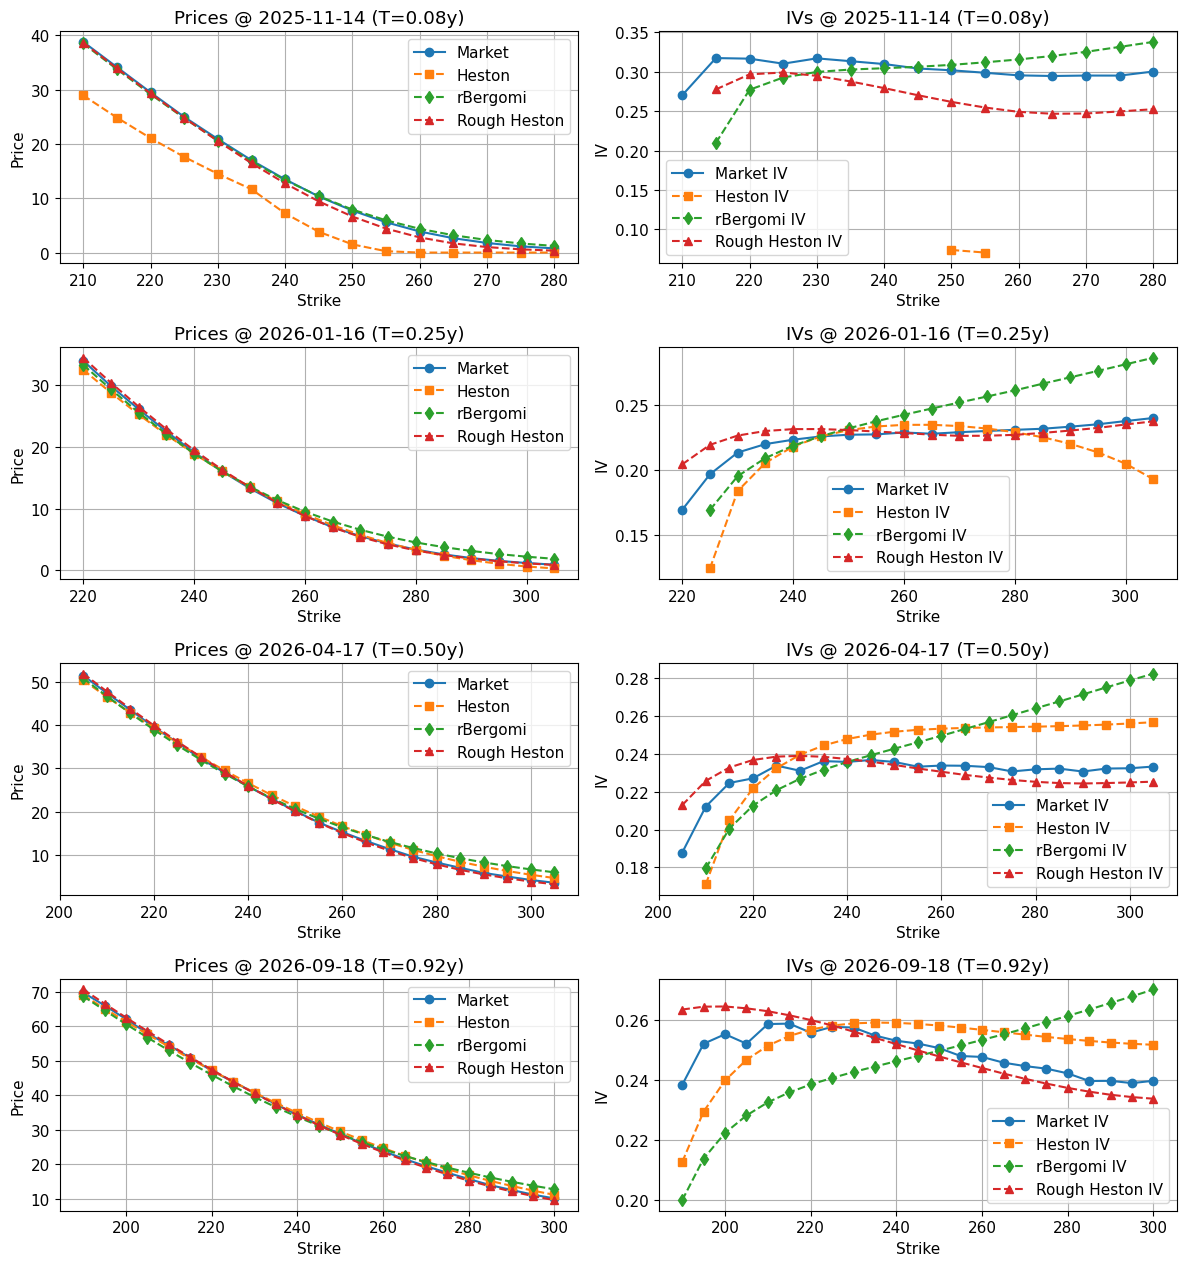

In [20]:

def model_smile_iv_heston(sm):
    S0,r,q,T,K = sm["S0"],sm["r"],sm["q"],sm["T"],sm["strikes"]
    px = heston_smile_prices(S0,r,q,T,K,params_h)
    iv = prices_to_ivs(S0,r,q,T,K,px,"call")
    return px, iv

def model_smile_iv_rbergomi(sm, pars):
    S0,r,q,T,K = sm["S0"],sm["r"],sm["q"],sm["T"],sm["strikes"]
    H,eta,rho = pars["H"],pars["eta"],pars["rho"]
    xi0 = xi0_map.get(sm["expiry"], pars["xi0"])
    N_eff = int(np.ceil(rb_cfg.get('N_per_year', rb_cfg.get('N',256)) * T))
    N_eff = max(128, N_eff)
    t,S,_ = rbergomi_paths(S0=S0,T=T,N=N_eff,n_paths=rb_cfg['paths'],
                            H=H,eta=eta,rho=rho,xi0=xi0,r=r,q=q,seed=12345,
                            fgn_method=rb_cfg.get("fgn_method","davies-harte"))
    ST=S[:,-1]; DF=math.exp(-r*T)
    px=np.array([np.mean(DF*np.maximum(ST-Ki,0.0)) for Ki in K])
    iv=prices_to_ivs(S0,r,q,T,K,px,"call")
    return px, iv

def model_smile_iv_rough_heston(sm, pars):
    S0,r,q,T,K = sm["S0"],sm["r"],sm["q"],sm["T"],sm["strikes"]
    N_eff = int(np.ceil(rh_cfg.get('N_per_year', rh_cfg.get('N',256)) * T))
    N_eff = max(128, N_eff)
    t,S,_ = rough_heston_paths(
        S0=S0, v0=pars['v0'], T=T, N=N_eff, n_paths=rh_cfg['paths'],
        H=pars["H"], kappa=pars["kappa"], theta=pars["theta"],
        eta=pars["eta"], rho=pars["rho"], r=r, q=q,
        seed=22222, batch_size=rh_cfg.get("batch_size", 2048),
        use_numba=rh_cfg.get("use_numba", True),
    )
    ST = S[:,-1]
    DF = math.exp(-r*T)
    px = np.array([np.mean(DF*np.maximum(ST-Ki,0.0)) for Ki in K])
    iv = prices_to_ivs(S0,r,q,T,K,px,"call")
    return px, iv
rows=[]
for sm in smiles:
    S0,r,q,T,K,mids = sm["S0"],sm["r"],sm["q"],sm["T"],sm["strikes"],sm["mids"]
    mkt_iv = prices_to_ivs(S0,r,q,T,K,mids,"call")

    px_h, iv_h   = model_smile_iv_heston(sm)
    px_rb, iv_rb = model_smile_iv_rbergomi(sm, best_rb)
    px_rh, iv_rh = model_smile_iv_rough_heston(sm, best_rh)

    def rmse(a,b):
        a,b=np.asarray(a,float), np.asarray(b,float)
        return float(np.sqrt(np.nanmean((a-b)**2)))

    rows.append(dict(expiry=sm["expiry"], T=T,
                     rmse_px_h=rmse(px_h,mids), rmse_iv_h=rmse(iv_h,mkt_iv),
                     rmse_px_rb=rmse(px_rb,mids), rmse_iv_rb=rmse(iv_rb,mkt_iv),
                     rmse_px_rh=rmse(px_rh,mids), rmse_iv_rh=rmse(iv_rh,mkt_iv)))

res = pd.DataFrame(rows).sort_values("T")
display(res)

print("Global RMSE (IV):",
      "Heston=",float(np.sqrt(np.nanmean(res["rmse_iv_h"]**2))),
      " rBergomi=",float(np.sqrt(np.nanmean(res["rmse_iv_rb"]**2))),
      " RoughHeston=",float(np.sqrt(np.nanmean(res["rmse_iv_rh"]**2))))

# Plot one figure per expiry comparing Market vs all three models (IVs)
n = len(smiles)
fig, axs = plt.subplots(n, 2, figsize=(12, 3.2*n), sharex=False)
if n==1: axs = np.array([axs])  # shape (1,2)
for i,sm in enumerate(smiles):
    S0,r,q,T,K,mids = sm["S0"],sm["r"],sm["q"],sm["T"],sm["strikes"],sm["mids"]
    mkt_iv = prices_to_ivs(S0,r,q,T,K,mids,"call")
    px_h, iv_h   = model_smile_iv_heston(sm)
    px_rb, iv_rb = model_smile_iv_rbergomi(sm, best_rb)
    px_rh, iv_rh = model_smile_iv_rough_heston(sm, best_rh)

    ax0, ax1 = axs[i,0], axs[i,1]
    ax0.plot(K, mids, "o-", label="Market")
    ax0.plot(K, px_h, "s--", label="Heston")
    ax0.plot(K, px_rb,"d--", label="rBergomi")
    ax0.plot(K, px_rh,"^--", label="Rough Heston")
    ax0.set_title(f"Prices @ {sm['expiry']} (T={T:.2f}y)"); ax0.set_xlabel("Strike"); ax0.set_ylabel("Price"); ax0.grid(True); ax0.legend()

    ax1.plot(K, mkt_iv, "o-", label="Market IV")
    ax1.plot(K, iv_h, "s--", label="Heston IV")
    ax1.plot(K, iv_rb,"d--", label="rBergomi IV")
    ax1.plot(K, iv_rh,"^--", label="Rough Heston IV")
    ax1.set_title(f"IVs @ {sm['expiry']} (T={T:.2f}y)"); ax1.set_xlabel("Strike"); ax1.set_ylabel("IV"); ax1.grid(True); ax1.legend()

plt.tight_layout(); plt.show()



## 5) Tips & Extensions

- **Variance reduction (MC)**: use **antithetic** normals and a **control variate** (e.g., Black–Scholes) for vanillas to reduce noise drastically.
- **Common Random Numbers (CRN)**: keep RNG seeds **fixed per expiry** inside the objective for smoother calibrations.
- **Grid \(H\)**: fix or grid \(H\in\{0.06,0.10,0.14,0.20\}\), calibrate other params, then pick the best — stabilizes rough models.
- **Weights**: vega-weight in IV-space; down-weight deep wings (low vegas).
- **Parallelize**: run multistarts in parallel; batch MC to utilize BLAS threads.
- **Deterministic rough pricing**: for Rough Heston, explore **fractional Riccati / CF** (El Euch & Rosenbaum) for Heston-like speed.
